In [ ]:
n_pokemon = 898
# Download all pokemons, save to directory
import requests
import shutil
import os
from multiprocessing.pool import ThreadPool
img_urls = ['https://www.serebii.net/pokedex-swsh/icon/','.png']
save_dir = 'downloads'

def download_img(url, save_path):
    re = requests.get(url, stream=True)
    if(re.status_code==200):
        with open(save_path, 'wb') as f:
            re.raw.decode_content = True
            shutil.copyfileobj(re.raw, f)

def download_img_wrapper(i):
    download_img(img_urls[0]+str(i+1).zfill(3)+img_urls[1],
                 os.path.join(os.getcwd(), save_dir, '{}.png'.format(i)))

pokemon_indices = [i for i in range(n_pokemon)]
ThreadPool(5).imap_unordered(download_img_wrapper, pokemon_indices)
#for i in range(n_pokemon):
#    img_url = img_urls[0]+str(i+1).zfill(3)+img_urls[1]
#    re = requests.get(img_url, stream=True)
#    if(re.status_code==200):
#        save_path = os.path.join(os.getcwd(), save_dir, '{}.png'.format(i))
#        with open(save_path, 'wb') as f:
#            re.raw.decode_content = True
#            shutil.copyfileobj(re.raw, f)


In [1]:
import torch
print(*torch.__config__.show().split("\n"), sep="\n")
print(torch.device.type)

PyTorch built with:
  - C++ Version: 199711
  - MSVC 192829337
  - Intel(R) Math Kernel Library Version 2020.0.2 Product Build 20200624 for Intel(R) 64 architecture applications
  - Intel(R) MKL-DNN v2.1.2 (Git Hash 98be7e8afa711dc9b66c8ff3504129cb82013cdb)
  - OpenMP 2019
  - CPU capability usage: AVX2
  - Build settings: BLAS_INFO=mkl, BUILD_TYPE=Release, CXX_COMPILER=C:/w/b/windows/tmp_bin/sccache-cl.exe, CXX_FLAGS=/DWIN32 /D_WINDOWS /GR /EHsc /w /bigobj -DUSE_PTHREADPOOL -openmp:experimental -IC:/w/b/windows/mkl/include -DNDEBUG -DUSE_KINETO -DLIBKINETO_NOCUPTI -DUSE_FBGEMM -DUSE_XNNPACK -DSYMBOLICATE_MOBILE_DEBUG_HANDLE, LAPACK_INFO=mkl, PERF_WITH_AVX=1, PERF_WITH_AVX2=1, PERF_WITH_AVX512=1, TORCH_VERSION=1.9.0, USE_CUDA=0, USE_CUDNN=OFF, USE_EXCEPTION_PTR=1, USE_GFLAGS=OFF, USE_GLOG=OFF, USE_MKL=ON, USE_MKLDNN=ON, USE_MPI=OFF, USE_NCCL=OFF, USE_NNPACK=OFF, USE_OPENMP=ON, 

<attribute 'type' of 'torch.device' objects>


In [2]:
# Parameters

n_pokemon = 898
# hyperparameters

SEED_SIZE = 16 # latent variable
DEVICE = 'cpu'
BATCH_SIZE = 32
IMAGE_SIZE = 64

In [ ]:
# torch ImageFolder does not support alpha, and we want to convert the fully transparent
# parts to white:
from PIL import Image

for i in range(0, n_pokemon):
    png = Image.open('downloads/{}.png'.format(i)).convert('RGBA')
    background = Image.new('RGBA', png.size, (0, 0, 0))
    alpha_composite = Image.alpha_composite(background, png)
    alpha_composite.save('raw_dataset/class/{}.png'.format(i), 'PNG', quality=100)

In [4]:
# Get maximum dimensions for the images to determine input dimensions
from PIL import Image
import os.path

MAX_WIDTH = 0
MAX_HEIGHT = 0
for i in range(n_pokemon):
    filename = os.path.join('raw_dataset', 'class', '{}.png'.format(i))
    img = Image.open(filename)
    MAX_WIDTH = max(img.size[0], MAX_WIDTH)
    MAX_HEIGHT = max(img.size[1], MAX_HEIGHT)

print(MAX_WIDTH, MAX_HEIGHT)


59 52


In [3]:
import torch
import numpy as np

class PadToSize:
	def __init__(self, width, height):
		self.width = width
		self.height = height
	def __call__(self, image):
		h = image.shape[1]
		w = image.shape[2]
		diff_h = self.height-h
		diff_w = self.width-w
		ph1 = diff_h//2
		ph2 = diff_h - ph1
		pw1 = diff_w//2
		pw2 = diff_w - pw1
		#image = np.where(image==0, 255, image)
		return torch.from_numpy(np.pad(image, pad_width=((0, 0),(ph1, ph2),(pw1, pw2)), mode='constant', constant_values=0)) # whiten

In [4]:
# create and load the dataset
from torchvision import transforms, datasets
from torch.utils.data import ConcatDataset
import torch
import os

IMAGE_SIZE = 64

data_folder = os.path.join(os.getcwd(),'raw_dataset')
dataset = datasets.ImageFolder(data_folder, transform=transforms.Compose([
    transforms.ToTensor(),
    PadToSize(IMAGE_SIZE, IMAGE_SIZE),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
    
]))
mirrored_dataset = datasets.ImageFolder(data_folder, transform=transforms.Compose([
    transforms.RandomHorizontalFlip(p=1.0),
    transforms.ToTensor(),
    PadToSize(IMAGE_SIZE, IMAGE_SIZE),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
    
]))
color_jittered_dataset = datasets.ImageFolder(data_folder, transform=transforms.Compose([
    transforms.ToTensor(),
    PadToSize(IMAGE_SIZE, IMAGE_SIZE),
    transforms.ColorJitter(0.5, 0.5, 0.5),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
    
]))
color_jitter_flipped_dataset = datasets.ImageFolder(data_folder, transform=transforms.Compose([
    transforms.RandomHorizontalFlip(p=1.0),
    transforms.ToTensor(),
    PadToSize(IMAGE_SIZE, IMAGE_SIZE),
    transforms.ColorJitter(0.5, 0.5, 0.5),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
    
]))

combined = ConcatDataset([dataset, mirrored_dataset, color_jittered_dataset, color_jitter_flipped_dataset])

dataloader = torch.utils.data.DataLoader(combined, BATCH_SIZE, shuffle=True)

(array([10713,     0,     0,    11,   274,   177,   149,    86,   155,
          723], dtype=int64),
 array([-1. , -0.8, -0.6, -0.4, -0.2,  0. ,  0.2,  0.4,  0.6,  0.8,  1. ],
       dtype=float32))

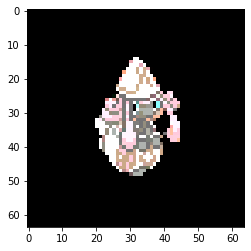

In [5]:
%matplotlib inline
import matplotlib.pyplot as plt

def normalize(data):
    return (data - np.min(data)) / np.ptp(data)

def show(img, save=False, path=None):
    if type(img) is not np.ndarray:
        img = img.numpy()
    img = normalize(img)
    plt.imshow(np.transpose(img, (1,2,0)), vmin=-1, vmax=1)
    if save:
        plt.savefig(path)

sample = next(iter(dataloader))[0][0]
# show a random image
show(sample)
# get tensor shape
np.histogram(sample)

In [6]:

class Discriminator(torch.nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.input_stack = torch.nn.Sequential(
            torch.nn.Conv2d(3, IMAGE_SIZE, kernel_size=4, stride=2, padding=1, bias=False),
            torch.nn.BatchNorm2d(64),
            torch.nn.LeakyReLU(0.2, inplace=True),
        ) # 64x32x32
        self.stack0 = torch.nn.Sequential(
            torch.nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1, bias=False),
            torch.nn.BatchNorm2d(128),
            torch.nn.LeakyReLU(0.2, inplace=True),
        ) # 128x16x16
        self.stack1 = torch.nn.Sequential(
            torch.nn.Conv2d(128, 128, kernel_size=4, stride=2, padding=1, bias=False),
            torch.nn.BatchNorm2d(128),
            torch.nn.LeakyReLU(0.2, inplace=True),
        ) # 128x8x8
        self.stack2 = torch.nn.Sequential(
            torch.nn.Conv2d(128, 128, kernel_size=4, stride=2, padding=1, bias=False),
            torch.nn.BatchNorm2d(128),
            torch.nn.LeakyReLU(0.2, inplace=True),
        ) # 128x4x4
        self.output = torch.nn.Sequential(
            torch.nn.Conv2d(128, 1, kernel_size=4, stride=1, padding=0, bias=False),
            torch.nn.Flatten(),
            torch.nn.Sigmoid()
        )

    def forward(self, x):
        x = self.input_stack(x)
        x = self.stack0(x)
        x = self.stack1(x)
        x = self.stack2(x)
        x = self.output(x)
        return x



In [7]:
class Generator(torch.nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        self.input_stack = torch.nn.Sequential(
            torch.nn.ConvTranspose2d(SEED_SIZE, 128, kernel_size=4, padding=0, stride=1, bias=False),
            torch.nn.BatchNorm2d(128),
            torch.nn.ReLU(True),
        ) # 64x32x32
        self.stack0 = torch.nn.Sequential(
            torch.nn.ConvTranspose2d(128, 128, kernel_size=4, padding=1, stride=2, bias=False),
            torch.nn.BatchNorm2d(128),
            torch.nn.ReLU(True),
        ) # 128x16x16
        self.stack1 = torch.nn.Sequential(
            torch.nn.ConvTranspose2d(128, 128, kernel_size=4, padding=1, stride=2, bias=False),
            torch.nn.BatchNorm2d(128),
            torch.nn.ReLU(True),
        ) # 128x8x8
        self.stack2 = torch.nn.Sequential(
            torch.nn.ConvTranspose2d(128, 64, kernel_size=4, padding=1, stride=2, bias=False),
            torch.nn.BatchNorm2d(64),
            torch.nn.ReLU(True),
        ) # 128x4x4
        self.output = torch.nn.Sequential(
            torch.nn.ConvTranspose2d(64, 3, kernel_size=4, padding=1, stride=2, bias=False),
            torch.nn.Tanh()
        )

    def forward(self, x):
        x = self.input_stack(x)
        x = self.stack0(x)
        x = self.stack1(x)
        x = self.stack2(x)
        x = self.output(x)
        return x


In [8]:
def train_discriminator(discriminator, generator, real_pokemon, optimizer):
    optimizer.zero_grad()
    real_predictions = discriminator(real_pokemon)
    real_labels = torch.rand(real_pokemon.size(0), 1, device=DEVICE)*0.1
    real_loss = torch.nn.functional.binary_cross_entropy(real_predictions, real_labels)
    real_score = torch.mean(real_predictions).item()

    latent_seeds = torch.randn(BATCH_SIZE, SEED_SIZE, 1, 1, device=DEVICE)
    fake_pokemon = generator(latent_seeds)
    fake_predictions = discriminator(fake_pokemon)
    fake_labels = torch.rand(fake_pokemon.size(0), 1, device=DEVICE)*0.1 + 0.9
    fake_loss = torch.nn.functional.binary_cross_entropy(fake_predictions, fake_labels)
    fake_score = torch.mean(fake_predictions).item()

    total_loss = real_loss + fake_loss
    total_loss.backward()
    optimizer.step()

    return total_loss.item(), real_score, fake_score

def train_generator(generator, discriminator, optimizer):
   
    optimizer.zero_grad()
    
    latent_seeds = torch.randn(BATCH_SIZE, SEED_SIZE, 1, 1, device=DEVICE)
    fake_pokemon = generator(latent_seeds)

    discriminator_predictions = discriminator(fake_pokemon)
    labels = torch.zeros(fake_pokemon.size(0), 1, device=DEVICE) 
    loss = torch.nn.functional.binary_cross_entropy(discriminator_predictions, labels)
    
    loss.backward()
    optimizer.step()
    
    return loss.item()


In [9]:
import os

def save_results(epoch, seed, generator, display=False):
    generated = generator(seed)
    images = [generated[i].detach() for i in range(len(generated))]
    concatenated_images = np.concatenate(images, axis=2)
    show(concatenated_images, save=True, path='progression/{}.png'.format(epoch))


def train(epochs, learning_rate, discriminator, generator, reference_seed, start_epoch=0):
    # Track losses and scores
    disc_losses = []
    disc_scores = []
    gen_losses = []
    gen_scores = []
    
    # Create the optimizers
    disc_optimizer = torch.optim.Adam(discriminator.parameters(), lr=learning_rate, betas=(0.5, 0.9))
    gen_optimizer = torch.optim.Adam(generator.parameters(), lr=learning_rate, betas=(0.5, 0.9))
    
    # Run the loop
    for epoch in range(start_epoch, epochs):
        # Go through each image
        for batch, (real_images, _) in enumerate(dataloader):
            # Train the discriminator
            disc_loss, real_score, gen_score = train_discriminator(discriminator, generator, real_images, disc_optimizer)

            # Train the generator
            gen_loss = train_generator(generator, discriminator, gen_optimizer)
        
        # Collect results
        disc_losses.append(disc_loss)
        disc_scores.append(real_score)
        gen_losses.append(gen_loss)
        gen_scores.append(gen_score)
        
        # Print the losses and scores
        print("Epoch [{}/{}], gen_loss: {:.4f}, disc_loss: {:.4f}, real_score: {:.4f}, gen_score: {:.4f}".format(
            epoch, epochs, gen_loss, disc_loss, real_score, gen_score))
        
        # Save model
        if epoch % 10 == 0:
            torch.save(discriminator.state_dict(), 'models/discriminator.pth')
            torch.save(generator.state_dict(), 'models/generator.pth')
        # Save the images and show the progress
        save_results(epoch=epoch, seed=reference_seed, generator=generator, display=True)
    
    # Return stats
    return disc_losses, disc_scores, gen_losses, gen_scores


Epoch [0/3], gen_loss: 5.9962, disc_loss: 1.1730, real_score: 0.0003, gen_score: 0.7429
Epoch [1/3], gen_loss: 3.3530, disc_loss: 0.4161, real_score: 0.0310, gen_score: 0.9457
Epoch [2/3], gen_loss: 2.8616, disc_loss: 0.3640, real_score: 0.0544, gen_score: 0.9500


([1.173016905784607, 0.41612815856933594, 0.3640170097351074],
 [0.0002803262905217707, 0.030995260924100876, 0.0544341541826725],
 [5.996187686920166, 3.353036642074585, 2.8615822792053223],
 [0.7429112792015076, 0.9457259178161621, 0.950036346912384])

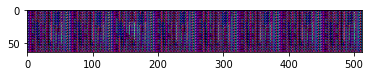

In [14]:
# Use this for new model training with intel gpu

DEVICE = 'cpu'
discriminator = Discriminator().to(DEVICE)
generator = Generator().to(DEVICE)
train(epochs=3, 
learning_rate=0.01, 
discriminator=discriminator, 
generator=generator, 
reference_seed=torch.randn(8, SEED_SIZE, 1, 1, device=DEVICE),
start_epoch=0)

In [ ]:
# Use this to make use of previous model and continue training

discriminator = Discriminator().to(DEVICE)
generator = Generator().to(DEVICE)
discriminator.load_state_dict(torch.load('models/discriminator.pth'))
generator.load_state_dict(torch.load('models/generator.pth'))

train(epochs=300, 
learning_rate=0.01, 
discriminator=discriminator, 
generator=generator, 
reference_seed=torch.randn(8, SEED_SIZE, 1, 1, device=DEVICE),
start_epoch=21)